In [1]:
# Updated imports for 2025 standards
import numpy as np
import pandas as pd  # Recommended for data handling
from util import load_hypocenters, PuuOo, load_puuoo_eqs, prune_data
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Import data

In [2]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

p = PuuOo(eruption_csv_path)
time, lat, lon, depth, mag = load_puuoo_eqs(eq_csv_path)
#print(len(time), time[:100])

#time, lat, lon, depth, mag = prune_data(time, lat, lon, depth, mag, p)
#print(len(time))

### NB: Don't prune the data. 
We can have eqs before the start of the eruption catalog. 

In [3]:
def GetTimeToEruption (EQtime, p):
    """
    For each earthquake, determine the time TO eruption in seconds. 
    If you want it in other units, just convert outside the function.
    """
    
    SecsToEruption = np.zeros(len(EQtime))

    for di in range(len(EQtime)):

        NextEruptions = [i for i in p.dates if i>EQtime[di]]

        if p.was_erupting(EQtime[di]):
            SecsToEruption[di] = 0

        elif not NextEruptions:
            SecsToEruption[di] = np.nan

        else:        
            timediff = NextEruptions[0] - EQtime[di]
            SecsToEruption[di] = timediff.days*24*3600 + timediff.seconds
            
    
    return SecsToEruption


In [4]:
def GetTimeSinceEruption (EQtime, p):
    """
    For each earthquake, determine the time SINCE eruption in seconds. 
    If you want it in other units, just convert outside the function.
    """
    
    SecsSinceEruption = np.zeros(len(EQtime))
    
    for di in range(len(EQtime)):
        PrevEruption = [i for i in p.dates if EQtime[di]>i]
        
        if p.was_erupting(EQtime[di]):
            SecsSinceEruption[di] = 0

        elif not PrevEruption:
            SecsSinceEruption[di] = np.nan

        else:        
            PrevEruptionIndex = p.dates.index(PrevEruption[-1])
            timediff = EQtime[di] - PrevEruption[-1]
            SecsSinceEruption[di] = timediff.days*24*3600 + timediff.seconds - p.length[PrevEruptionIndex]*3600
            
    return SecsSinceEruption
    

In [5]:
def GetEQRates (EQtime):
    """
    Returns the number of earthquakes in the 
    last day, last week (7 days) and last month (30 days) 
    leading up to each earthquake
    """
    
    EQsLastDay   = np.zeros(len(EQtime))
    EQsLastWeek  = np.zeros(len(EQtime))
    EQsLastMonth = np.zeros(len(EQtime))
    
    for di in range(len(EQtime)):
        timediff = [EQtime[di] - EQtime[ti] for ti in range(len(EQtime))]
        
        EQsLastDay[di]   = len([i for i in range(len(EQtime)) if timediff[i].days==0 and EQtime[di]>EQtime[i]])
        EQsLastWeek[di]  = len([i for i in range(len(EQtime)) if timediff[i].days<=7 and timediff[i].days>=0 and EQtime[di]>EQtime[i]])
        EQsLastMonth[di] = len([i for i in range(len(EQtime)) if timediff[i].days<=30 and timediff[i].days>=0 and EQtime[di]>EQtime[i]])
    
    return EQsLastDay, EQsLastWeek, EQsLastMonth
        

    

In [6]:
SecsToEruption = GetTimeToEruption(time, p)
SecsSinceEruption = GetTimeSinceEruption(time, p)
EQsLastDay, EQsLastWeek, EQsLastMonth = GetEQRates(time)


(6485,)
0.0
0.0


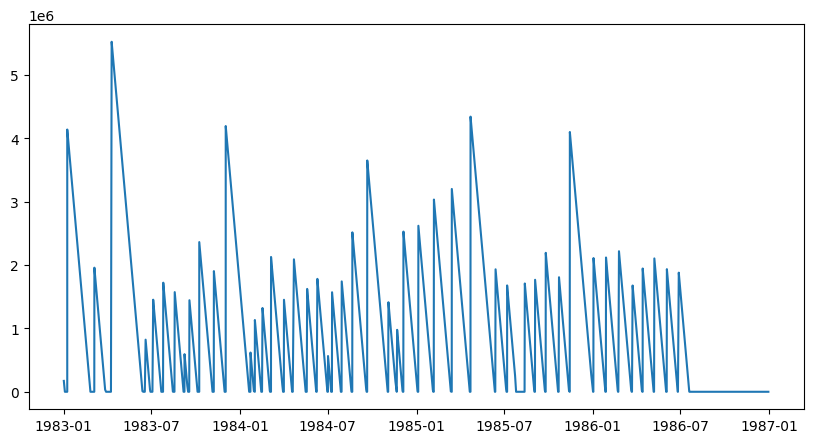

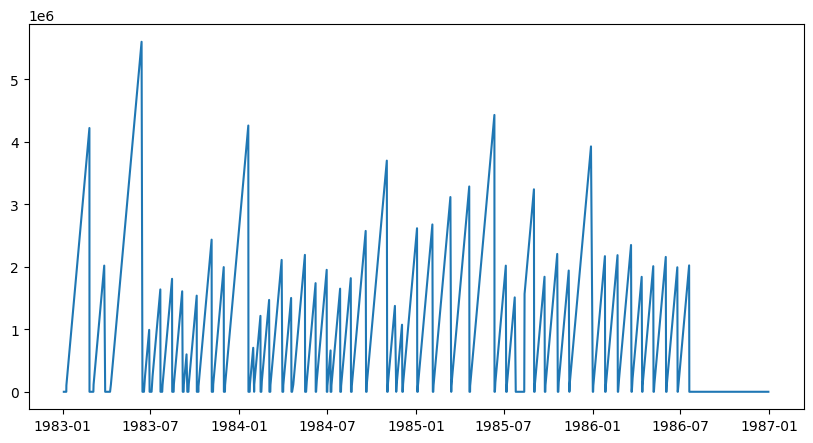

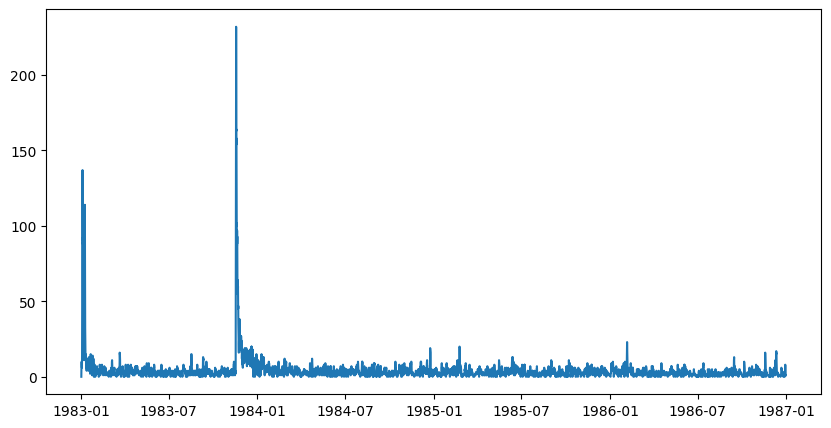

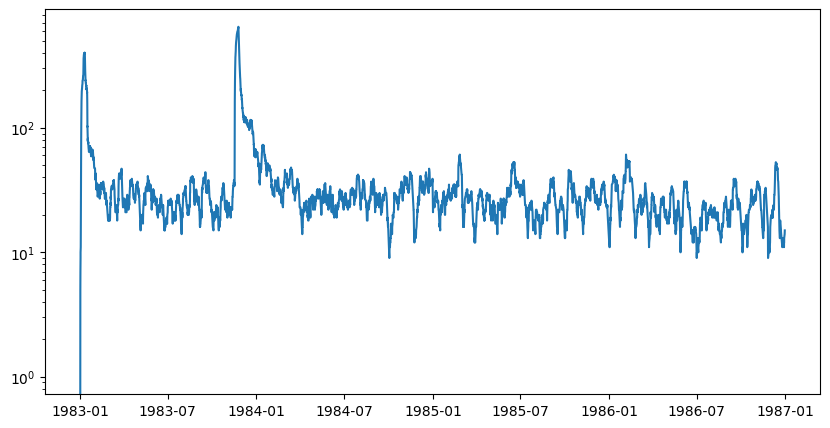

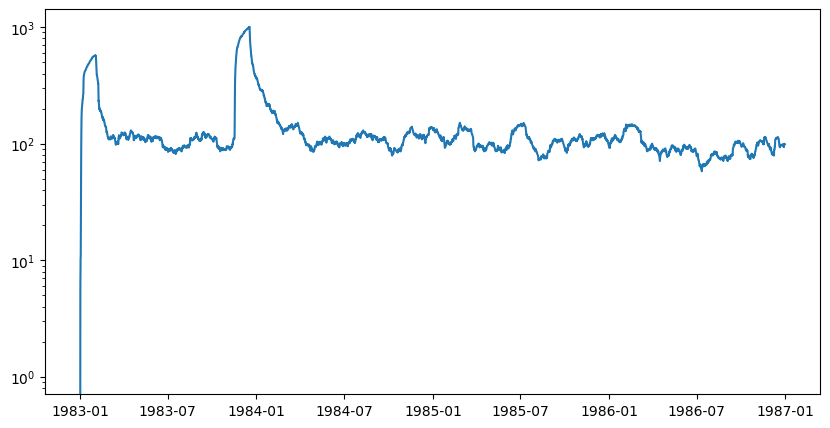

In [7]:
# check rates
print(EQsLastDay.shape)

# make sure we have no negative times
print(np.nanmin(SecsToEruption))
print(np.nanmin(SecsSinceEruption))

# plot to see if we did this right
plt.figure(figsize=(10,5))
plt.plot(time, SecsToEruption)

plt.figure(figsize=(10,5))
plt.plot(time, SecsSinceEruption)

plt.figure(figsize=(10,5))
plt.plot(time, EQsLastDay)

plt.figure(figsize=(10,5))
plt.semilogy(time, EQsLastWeek)

plt.figure(figsize=(10,5))
plt.semilogy(time, EQsLastMonth)